     ';## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
%matplotlib inline

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'cv'

## Select one image and correct it for distortion

In [3]:
img = cv2.imread(images[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imshow('und',undist)
cv2.imwrite('../camera_cal/undistorted/undistorted1.jpg',undist)
cv2.waitKey(500)
cv2.destroyAllWindows()

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


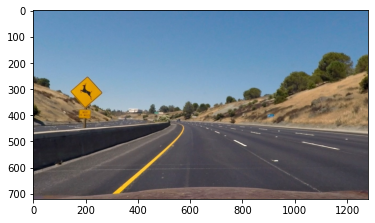

In [122]:
#reading in an image
image = cv2.imread('../test_images/test2.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
cv2.imwrite('../camera_cal/undistorted/undistorted3.jpg',image)
plt.imshow(undistorted)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

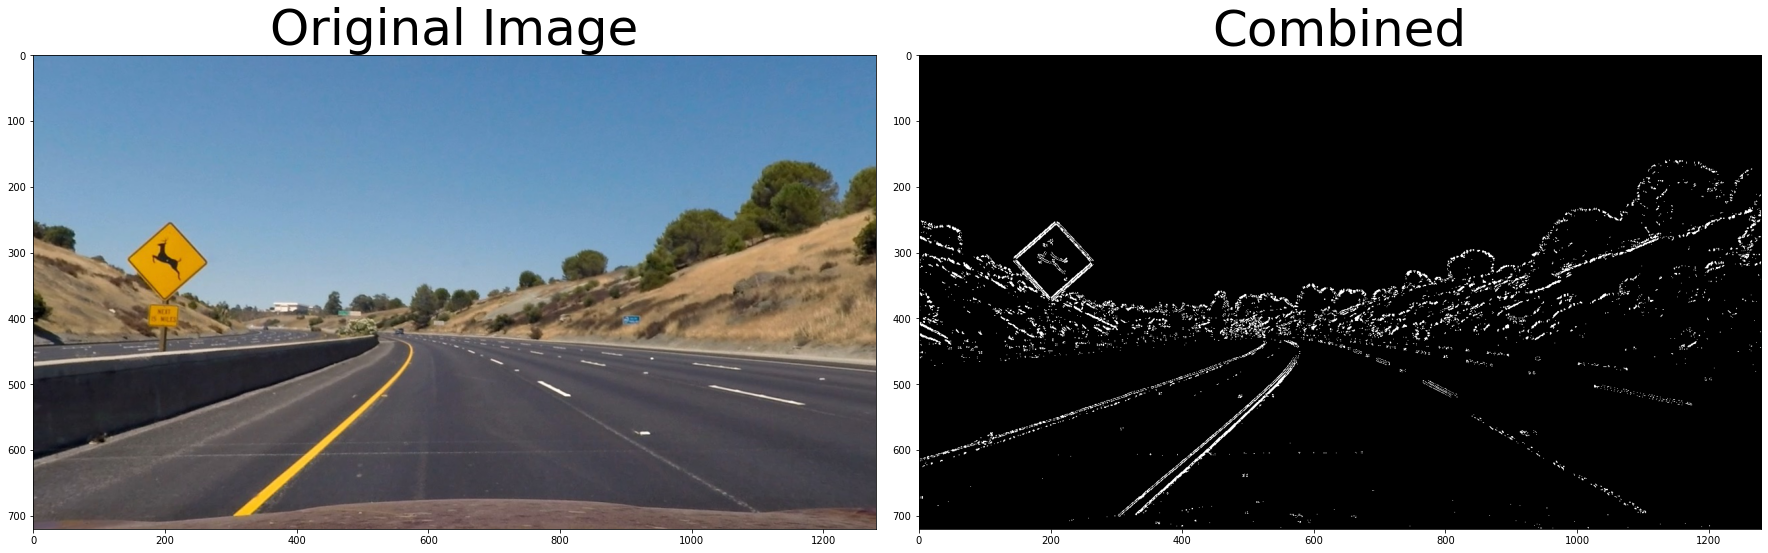

In [123]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel, mag_thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(graddir)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # 6) Return this mask as your binary_output image
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return dir_binary

def channel_select(img,channel, thresh):
    if channel == 'r':
        channel = img[:,:,0]
    if channel == 'g':
        channel = hls[:,:,1]
    if channel == 'b':
        channel = hls[:,:,2]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        channel = hls[:,:,0]
    if channel == 'l':
        channel = hls[:,:,1]
    if channel == 's':
        channel = hls[:,:,2]
    channel_output = np.zeros_like(channel)
    channel_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return channel_output
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
def thresholding(image, ksize):
    hls_binary = channel_select(image, channel = 's',thresh=(170, 255))
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(1.1, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (grady == 1) | (hls_binary==1)&(mag_binary == 1) & (dir_binary == 1)] = 1
    return combined

combined = thresholding(undistorted, 3)
cv2.imwrite('../camera_cal/undistorted/lanes_binary.jpg',combined*255)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [124]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    #second Approach
    x1l = []
    y1l = []
    x2l = []
    y2l = []
    x1r = []
    y1r = []
    x2r = []
    y2r = []
    for line in lines:
        x1,y1,x2,y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        if slope > 0: #right line
            x1r.extend([x1])
            y1r.extend([y1])
            x2r.extend([x2])
            y2r.extend([y2])
        elif slope < 0: #left line
            x1l.extend([x1])
            y1l.extend([y1])
            x2l.extend([x2])
            y2l.extend([y2])
    #averaging
    x1r_av = np.mean(x1r)
    y1r_av = np.mean(y1r)
    x2r_av = np.mean(x2r)
    y2r_av = np.mean(y2r) 
    x1l_av = np.mean(x1l)
    y1l_av = np.mean(y1l)
    x2l_av = np.mean(x2l)
    y2l_av = np.mean(y2l) 
    #average slope
    avg_slope_r = (y2r_av-y1r_av)/(x2r_av-x1r_av)
    avg_slope_l = (y2l_av-y1l_av)/(x2l_av-x1l_av)
    #average intercept
    avg_b_r = y1r_av - avg_slope_r*(x1r_av)
    avg_b_l = y1l_av - avg_slope_l*(x1l_av)
    #Calcuating the expremeties of the boundary lines
    Y1l = image.shape[0]
    X1l = int((Y1l - avg_b_l)/avg_slope_l)
    Y1r = image.shape[0]
    X1r = int((Y1r - avg_b_r)/avg_slope_r)
    Y2l = int(image.shape[0]*0.6)
    X2l = int((Y2l - avg_b_l)/avg_slope_l)
    Y2r = int(image.shape[0]*0.6)
    X2r = int((Y2r - avg_b_r)/avg_slope_r )  
    cv2.line(img, (X1l, Y1l), (X2l, Y2l), color, thickness)
    cv2.line(img, (X1r, Y1r), (X2r, Y2r), color, thickness)
    cv2.line(img, (X2l, Y2l), (X2r, Y2r), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


## Processing the undistorted image and plotting lane lines

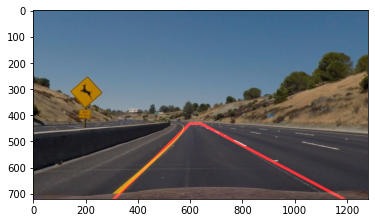

In [125]:
vertices = np.array([[[int(image.shape[1]*0.14), image.shape[0]],[int(image.shape[1]*0.47), int(image.shape[0]*0.6)],[int(image.shape[1]*0.53), int(image.shape[0]*0.6)],[int(image.shape[1]*0.86), image.shape[0]]]])
thresh_undistorted = np.array(thresholding(undistorted, 3)*255, dtype = int)
roi_undistorted = region_of_interest(thresh_undistorted, vertices)
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/150 # angular resolution in radians of the Hough grid
threshold = 5   # minimum number of votes (intersections in Hough grid cell)
min_line_len = 20 #minimum number of pixels making up a line
max_line_gap = 2   # maximum gap in pixels between connectable line segments
line_image = hough_lines(roi_undistorted.astype(np.uint8), rho, theta, threshold, min_line_len, max_line_gap)#original
output_undistorted = cv2.merge([thresh_undistorted,thresh_undistorted,thresh_undistorted]).astype(np.uint8)
weight_img = weighted_img(line_image, undistorted, α=0.8, β=1., γ=0.)
#weight_img = cv2.cvtColor(weight_img, cv2.COLOR_BGR2RGB)
plt.imshow(weight_img)
plt.savefig('../camera_cal/undistorted/thresh_undistorted_lane.png')


## Carrying out perspective transform and plotting lines

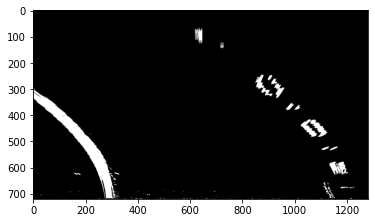

In [132]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]# select bottom half of the image
    histogram = np.sum(bottom_half, axis=0)# summ each index
    return histogram

vertices_warped = np.array([[[int(image.shape[1]*0), image.shape[0]],[int(image.shape[1]*0), int(image.shape[0]*0)],[int(image.shape[1]*1), int(image.shape[0]*0)],[int(image.shape[1]*1), image.shape[0]]]])
height = gray.shape[0]
width = gray.shape[1]
src = np.float32([[int(image.shape[1]*0), image.shape[0]],[int(image.shape[1]*0.47), int(image.shape[0]*0.61)],[int(image.shape[1]*0.53), int(image.shape[0]*0.61)],[int(image.shape[1]), image.shape[0]]])
dst = np.float32([[0,height],[0,0],[width,0],[width,height]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistorted, M, (width,height), flags=cv2.INTER_LINEAR) 
#thresholding the image
hls_binary = channel_select(warped, channel = 's',thresh=(170, 255))
gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(1.1, 1.3))
thresh_warped = np.zeros_like(dir_binary)
thresh_warped[(gradx == 1) | (hls_binary==1) | (mag_binary == 1) & (dir_binary == 1)] = 1# add & (grady == 1)
histogram = hist(thresh_warped)
left_lane = histogram[:histogram.shape[0]//2]
left_lane_index = np.where(left_lane == max(left_lane))
right_lane = histogram[histogram.shape[0]//2:]
right_lane_index = histogram.shape[0]//2 + np.where(right_lane == max(right_lane))[0]
output_warped = cv2.merge([thresh_warped*255,thresh_warped*255,thresh_warped*255]).astype(np.uint8)
# Visualize the resulting histogram
#plt.plot(histogram)
plt.imshow(output_warped)
plt.savefig('../camera_cal/undistorted/perspective_lane.png')

## Implementing siding window, identifying lans-pixels and fitting a polynomial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


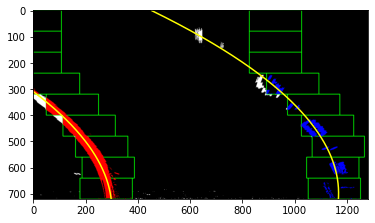

In [133]:
# Load our image
binary_warped = thresh_warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


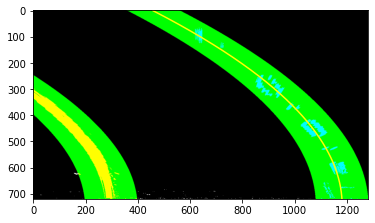

In [137]:
# Load our image - this should be a new frame since last time!
binary_warped = thresh_warped

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

## Curvature of the lane

In [141]:
def measure_curvature_pixels(left_fit, right_fit, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix)**2)**(1.5))/np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix)**2)**(1.5))/np.absolute(2*right_fit[0])  ## Implement the calculation of the right line here
    return left_curverad, right_curverad

img_shape = thresh_warped.shape
ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
y_eval = np.max(ploty)
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit, y_eval)

print(left_curverad, right_curverad)




344.49732157248843 345.40994522202317


In [69]:
left_lane[left_lane_index]

array([247.])